In [36]:
import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir() if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

The images are stored in byte format, andwe will read them into NumPy arrays that we will use to train and test our MLPimplementation. In order to do that, we will define the following helper function:

In [37]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        #Finally, we also normalized the pixels values in MNIST to the range -1 to 1(originally 0 to 255) via the following code line:
        images = ((images / 255.) - .5) * 2
 
    return images, labels


The load_mnist function returns two arrays, the first being an n x m dimensional NumPy array (images), where n is the number of samples and m is the number of features (here, pixels). The training dataset consists of 60,000 training digits and the test set contains 10,000 samples, respectively. The images in the MNIST dataset consist of 28 x 28 pixels, and each pixel is represented by a gray scale intensity value. Here, we unroll the 28 x 28 pixels into one-dimensional row vectors, which represent the rows in our images array (784 per row or image). The second array(labels) returned by the load_mnist function contains the corresponding target variable, the class labels (integers 0-9) of the handwritten digits.The way we read in the image might seem a little bit strange at first:>>> magic, n = struct.unpack('>II', lbpath.read(8))>>> labels = np.fromfile(lbpath, dtype=np.int8)

In [38]:
X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [39]:
X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


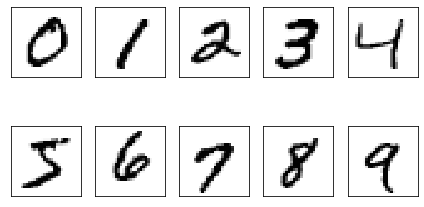

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()



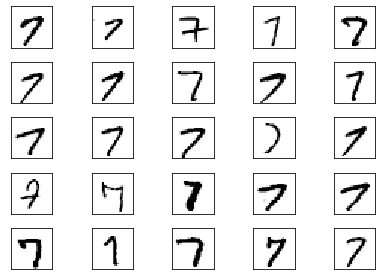

In [41]:


fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()



In [42]:
import numpy as np

np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [43]:
mnist = np.load('mnist_scaled.npz')
mnist.files


['X_train', 'y_train', 'X_test', 'y_test']

In [44]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

Note that we scaled the images on a pixel-by-pixel basis, which is different from the feature scaling approach that we took in previous chapters. Previously, we derived scaling parameters from the training set and used these to scale each column in the training set and test set. However, when working with image pixels, centering them at zero and rescaling them to a [-1, 1] range is also common and usually works well in practice

To get an idea of how those images in MNIST look, let's visualize examples of thedigits 0-9 after reshaping the 784-pixel vectors from our feature matrix into theoriginal 28 × 28 image that we can plot via Matplotlib's imshow function

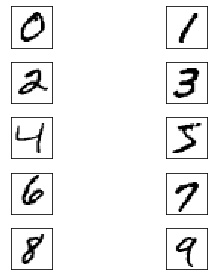

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5, ncols=2,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In addition, let's also plot multiple examples of the same digit to see how differentthe handwriting really is:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  


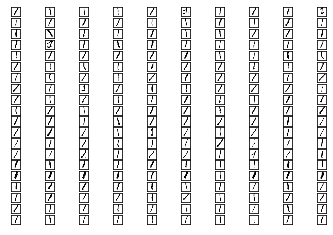

In [46]:
fig, ax = plt.subplots(nrows=20, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(200):
    img = X_train[y_train == 1][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

After we've gone through all the previous steps, it is a good idea to save the scaledimages in a format that we can load more quickly into a new Python session to avoidthe overhead of reading in and processing the data again. When we are working withNumPy arrays, an efficient yet most convenient method to save multidimensionalarrays to disk is NumPy's savez function
In short, the savez function is analogous to Python's pickle module that we used inChapter 9, Embedding a Machine Learning Model into a Web Application, butoptimized for storing NumPy arrays. The savez function produces zipped archivesof our data, producing .npz files that contain files in the .npy format;
Further, instead of using savez, we will use savez_compressed, which uses the same syntax as savez, but further compresses the output file down to substantially smaller file sizes
(approximately 22 MB versus approximately 400 MB in this case). The followingcode snippet will save both the training and test datasets to the archive file

In [47]:
#'mnist_scaled.npz':
import numpy as np
np.savez_compressed('mnist_scaled.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


After we created the .npz files, we can load the preprocessed MNIST image arrays using NumPy's load function as follows:

In [48]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

Using a list comprehension, we can retrieve all four data arrays as follows:

In [49]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

In [50]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [51]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=100, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

100/100 | Cost: 7909.96 | Train/Valid Acc.: 98.47%/97.78%  

l2: This is the  parameter for L2 regularization to decrease the degree of overfitting.
epochs: This is the number of passes over the training set.
eta: This is the learning rate .
??shuffle: This is for shuffling the training set prior to every epoch to prevent that the algorithm gets stuck in circles.
??seed: This is a random seed for shuffling and weight initialization.
??minibatch_size: This is the number of training samples in each mini-batch when splitting of the training data in each epoch for stochastic gradient descent.
The gradient is computed for each mini-batch separately instead of the entire  training data for faster learning.
Next, we train the MLP using 55,000 samples from the already shuffled MNISTtraining dataset and use the remaining 5,000 samples for validation during training.


As you may have noticed from the preceding code implementation, we implemented the fit method so that it takes four input arguments: training images, training labels,validation images, and validation labels. In neural network training, it is really usefulto already compare training and validation accuracy during training, which helps usjudge whether the network model performs well, given the architecture andhyperparameters

In general, training (deep) neural networks is relatively expensive compared with theother models we discussed so far. Thus, we want to stop it early in certaincircumstances and start over with different hyperparameter settings. Alternatively, ifwe find that it increasingly tends to overfit the training data (noticeable by anincreasing gap between training and validation set performance), we may want tostop the training early as well.Now, to start the training, we execute the following code:

In our NeuralNetMLP implementation, we also defined an eval_ attribute thatcollects the cost, training, and validation accuracy for each epoch so that we canvisualize the results using Matplotlib:

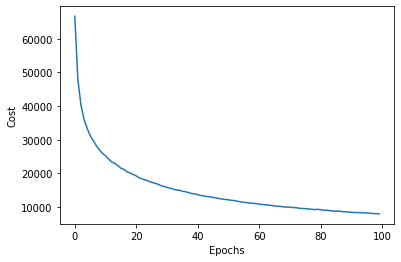

In [52]:
import matplotlib.pyplot as plt


plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

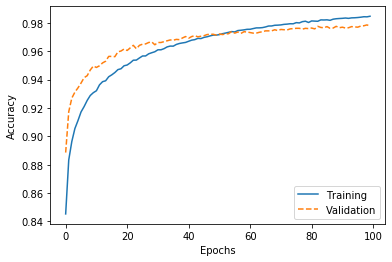

In [53]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

The plot reveals that the gap between training and validation accuracy increases themore epochs we train the network. At approximately the 50th epoch, the training andvalidation accuracy values are equal, and then, the network starts overfitting thetraining data.
Note that this example was chosen deliberately to illustrate the effect of overfittingand demonstrate why it is useful to compare the validation and training accuracyvalues during training. One way to decrease the effect of overfitting is to increase theregularization strength—for example, by setting l2=0.1 (decrease overfitting by increasing L2 parameter, originally l2=0.01 so we can set l2=0.1 to decrease overfitting effect)

Finally, let's evaluate the generalization performance of the model by calculating theprediction accuracy on the test set:

In [54]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.16%


To further fine-tune the model, we could change the number of hidden units, valuesof the regularization parameters, and the learning rate

Lastly, let's take a look at some of the images that our MLP struggles with:
We should now see a 5 x 5 subplot matrix where the first number in the subtitlesindicates the plot index, the second number represents the true class label (t), and thethird number stands for the predicted class label (p):

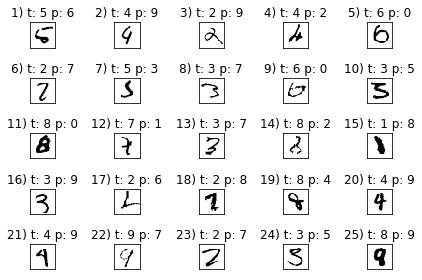

In [55]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('images/12_09.png', dpi=300)
plt.show()


In [56]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

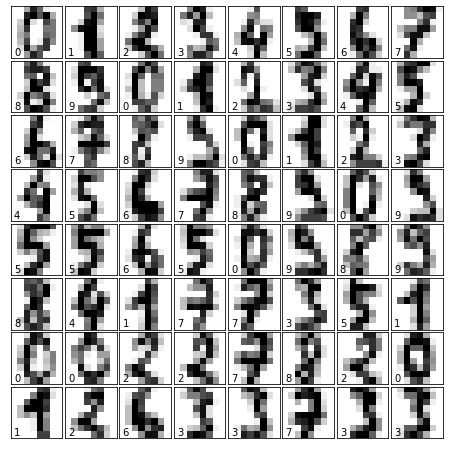

In [57]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [58]:
digits.data
print(digits.data)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


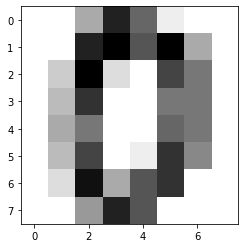

In [59]:
digits.data[0]
plt.imshow(digits.data[0].reshape(8,8), cmap='binary', interpolation='nearest')

In [62]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=2000, factor=.3, noise=.05, random_state=1)
#print(data)
#plt.scatter(X, y)

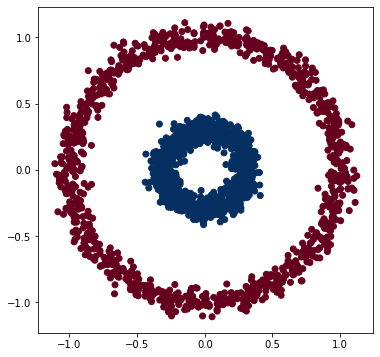

In [64]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0],X[:,1], c=y, cmap="RdBu")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

In [65]:
from urllib.request import urlretrieve
url = "https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/neuralnet.py"
urlretrieve(url, 'neuralnet.py' )

('neuralnet.py', <http.client.HTTPMessage at 0x120692710>)

In [66]:
from neuralnet import NeuralNetMLP

In [67]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [68]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=100, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

100/100 | Cost: 7909.96 | Train/Valid Acc.: 98.47%/97.78%  

In [69]:
nn = NeuralNetMLP(n_hidden=1, 
                  l2=0.01, 
                  epochs=100, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

100/100 | Cost: 149703.90 | Train/Valid Acc.: 23.28%/23.52% 

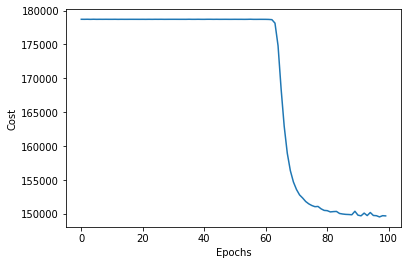

In [70]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

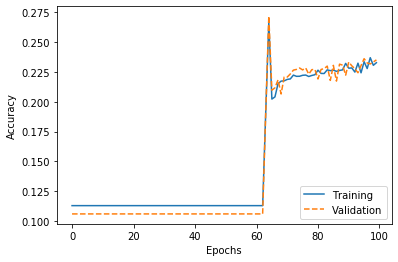

In [71]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [76]:
nn = NeuralNetMLP(n_hidden=1, 
                  l2=0.01, 
                  epochs=60, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

60/60 | Cost: 178708.96 | Train/Valid Acc.: 11.29%/10.60% 

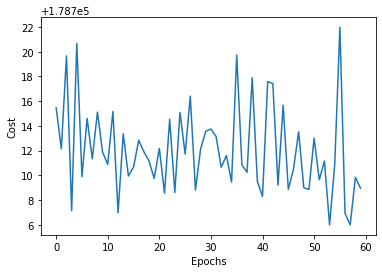

In [74]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

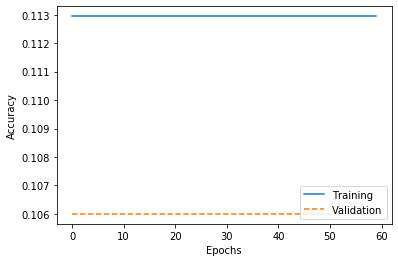

In [75]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('images/12_08.png', dpi=300)
plt.show()